# ConsistencyAI - Complete Pipeline

**A benchmark for evaluating LLM consistency across demographics**

By: Peter Banyas, Shristi Sharma, Alistair Simmons, Atharva Vispute (The Duke Phishermen)

---

## What This Notebook Does

This notebook demonstrates the complete ConsistencyAI workflow:

1. **Load Personas** - Fetch diverse personas from NVIDIA Nemotron dataset
2. **Generate Queries** - Create personalized queries for each persona
3. **Query LLMs** - Get responses from multiple language models
4. **Compute Similarity** - Analyze response consistency using embeddings
5. **Visualize Results** - Create heatmaps, leaderboards, and 3D plots
6. **Advanced Analysis** - Clustering and negative similarity detection

---

## Quick Start

**For a fresh run:** Execute each cell in order

**To resume from cache:** Use the "Load from cache" cells instead of running fresh

**To customize:** Edit the configuration in the setup cells

---


## Setup & Configuration


In [1]:
# Install dependencies (if needed)
import sys
import subprocess

try:
    subprocess.run([sys.executable, '-m', 'pip', 'install', '-q', '-r', 'requirements.txt'], check=False)
    print("Dependencies checked/installed")
except Exception as e:
    print(f"Warning: Could not install dependencies: {e}")


Dependencies checked/installed


In [2]:
# Import the ConsistencyAI package
from duplicity import (
    # Personas
    get_and_clean_personas,
    generate_queries_for_personas,
    load_latest_personas,
    
    # Queries
    query_llm_fast,
    query_llm_fast_resume,
    load_latest_results,
    load_latest_fast_results,
    
    # Similarity
    supercompute_similarities,
    collect_avg_scores_by_model,
    save_similarity_results,
    load_latest_similarity_results,
    load_similarity_results,
    
    # Visualization
    plot_similarity_matrix_with_values,
    plot_overall_leaderboard,
    plot_similarity_by_sphere,
    Embedding3DVisualizer,
    
    # Advanced Analysis
    analyze_and_cluster_embeddings,
    print_analysis_summary,
    
    # Central Analysis
    compute_central_analysis,
    print_central_analysis_summary,
    
    # Configuration
    config
)

import os
import numpy as np
import matplotlib.pyplot as plt

# Enable nested event loops for Jupyter compatibility
import nest_asyncio
nest_asyncio.apply()

print("All imports successful")
print("ConsistencyAI ready to use")
print("Jupyter compatibility enabled")


All imports successful
ConsistencyAI ready to use
Jupyter compatibility enabled


### API Key Configuration

**Important:** If you've already imported the duplicity package and then set your API key, you need to restart the kernel for the changes to take effect.

To restart: Kernel → Restart & Clear Output, then re-run all cells.


In [3]:
# Set your API keys here or via environment variables
# Uncomment and add your keys:
# config.set_openrouter_key("your-key-here")
# config.set_openai_key("your-key-here")  # Optional
# config.set_google_key("your-key-here")  # Optional

# Check if API key is set
if config.OPENROUTER_API_KEY:
    print("OPENROUTER_API_KEY is set")
else:
    print("Warning: OPENROUTER_API_KEY is not set")
    print("Set it with: config.set_openrouter_key('your-key')")


Set it with: config.set_openrouter_key('your-key')


---

## Experiment Configuration

**Customize your experiment here!**


In [ ]:
# ============================================================
# EXPERIMENT CONFIGURATION - CUSTOMIZE HERE!
# ============================================================

# Number of personas to test
NUM_PERSONAS = 50  # Start small for testing, increase for full experiments

# Topics to query about
TOPICS = [
    "Climate Change",
    "Vaccines",
    "Artificial Intelligence",
]

# Models to test
MODELS = [
    "x-ai/grok-4-fast",
    "anthropic/claude-sonnet-4.5",
    "google/gemini-2.5-flash",
]

# API routing configuration
ALL_OPEN_ROUTER = False  # Route non-OpenAI models through OpenRouter (OpenAI models always use direct API)

# Performance settings
INITIAL_BATCH_SIZE = 30
INITIAL_CONCURRENCY = 10
MAX_CONCURRENCY = 50
ADAPTIVE_MODE = True

# Experiment tag
EXPERIMENT_TAG = "demo_run"

In [ ]:
print("Experiment Configuration:")
print(f"   Personas: {NUM_PERSONAS}")
print(f"   Topics: {len(TOPICS)} ({', '.join(TOPICS)})")
print(f"   Models: {len(MODELS)}")
for model in MODELS:
    print(f"      - {model}")
total_queries_per_model = NUM_PERSONAS * len(TOPICS)
print(f"   Total queries: {total_queries_per_model * len(MODELS)}")


---

## Step 1: Load Personas

Fetch diverse personas from the NVIDIA Nemotron dataset.


In [5]:
# Fetch fresh personas
print(f"Fetching {NUM_PERSONAS} personas...")

personas = get_and_clean_personas(
    offset=0,
    length=NUM_PERSONAS,
    cache=True,
    tag=EXPERIMENT_TAG
)

num_personas = len(personas.get('rows', []))
print(f"Loaded {num_personas} personas")

# Show sample
if personas['rows']:
    sample = personas['rows'][0]['row']
    print(f"\nSample Persona:")
    print(f"   Age: {sample.get('age')}, Sex: {sample.get('sex')}")
    print(f"   Persona: {sample.get('persona', '')[:80]}...")



Fetching 50 personas...


Loaded 50 personas

Sample Persona:
   Age: 72, Sex: Male
   Persona: A disciplined, sociable visionary, Jonathan balances practicality with curiosity...


### ALT: Load Cached Personas

**Skip fetching** and load the most recent cached personas instead.


In [ ]:
# # ALTERNATIVE: Load cached personas instead of fetching
# # Uncomment to use cached data:

# personas = load_latest_personas()
# if personas:
#     num_personas = len(personas.get('rows', []))
#     print(f"Loaded {num_personas} personas from cache")
# else:
#     print("No cached personas found. Please run the cell above to fetch fresh personas.")


Loaded 50 personas from cache


---

## Step 2: Generate Queries

Create personalized queries for each persona and topic.


In [6]:
print(f"Generating queries for {len(TOPICS)} topics...")

queries = generate_queries_for_personas(personas, TOPICS)

total_queries_per_model = sum(len(topic_queries) for topic_queries in queries.values())
print(f"Generated {total_queries_per_model} queries per model")
print(f"   Total across all models: {total_queries_per_model * len(MODELS)}")


Generating queries for 3 topics...
Generated 150 queries per model
   Total across all models: 450


---

## Step 3: Query LLMs

Send queries to language models and collect responses.

**Features:** Adaptive concurrency, automatic retries, incremental saving, real-time progress


In [7]:
print("Starting LLM queries...")
print(f"   Estimated time: ~{(total_queries_per_model * len(MODELS)) / 10 / 60:.1f} minutes")
print("\\nNote: Progress is saved incrementally. You can stop and resume anytime!\\n")

results = query_llm_fast(
    nested_queries=queries,
    list_of_models=MODELS,
    initial_batch_size=INITIAL_BATCH_SIZE,
    initial_concurrency=INITIAL_CONCURRENCY,
    max_concurrency=MAX_CONCURRENCY,
    adaptive_mode=ADAPTIVE_MODE,
    all_open_router=ALL_OPEN_ROUTER,
    ensure_100_percent_success=True,
    save_incremental=True,
    max_retries=5
)

print("\\nAll queries complete!")
for model in results:
    total_responses = sum(len(personas) for personas in results[model].values())
    print(f"   {model}: {total_responses} responses")


Starting LLM queries...
   Estimated time: ~0.8 minutes
\nNote: Progress is saved incrementally. You can stop and resume anytime!\n
🎯 Starting FAST robust query processing (100% success mode):
   Models: 3
   Topics: 3
   Personas per topic: 50
   Total queries: 450
   Initial batch size: 30
   Initial concurrency: 10
   Max concurrency: 50
   Adaptive mode: True
   All OpenRouter: True
   Max retries: 5
   100% success mode: True
   Incremental saving: True
   Incremental interval: Every 1 batch(es)
   Incremental folder: /Users/peterbanyas/Desktop/Cyber/openai/duplicity3/consistencyAI/logs/incremental
📋 Created 450 expected task combinations (model×topic×persona)
   Total batches: 15
🚀 Processing batch 1/15 (30 queries, concurrency: 10, current batch size: 30)
✅ Batch 1 complete: 30 success, 0 failed, 26830 tokens, 30.1s
📈 Increasing batch size from 30 to 40 (success rate: 100.0%)
📝 Progress saved: 1/15 batches complete (ETA: 0:07:00)
📁 Incremental results saved: incremental_results_

### ALT: Load Cached Results

**Skip querying** and load the most recent LLM results instead. This saves time and API costs!


In [ ]:
# # ALTERNATIVE: Load cached query results instead of running fresh queries
# # Uncomment to use cached data:

# results = load_latest_fast_results()
# if results:
#     print("Loaded query results from cache!")
#     for model in results:
#         total_responses = sum(len(personas) for personas in results[model].values())
#         print(f"   {model}: {total_responses} responses")
# else:
#     print("No cached results found. Please run Step 3 above to query LLMs.")


Loaded query results from cache!
   x-ai/grok-4-fast: 150 responses
   anthropic/claude-sonnet-4.5: 150 responses
   google/gemini-2.5-flash: 150 responses


---

## Step 4: Compute Similarity

Analyze response consistency using semantic embeddings.


In [7]:
print("Computing semantic similarity matrices...")

matrices, dfs, persona_ids, embeddings = supercompute_similarities(results)

print(f"\\nSimilarity computation complete!")
print(f"   Matrices computed: {sum(len(topics) for topics in matrices.values())}")

# Save results
similarity_path = save_similarity_results(matrices, dfs, persona_ids, embeddings, tag=EXPERIMENT_TAG)
print(f"   Saved to: {similarity_path}")


Computing semantic similarity matrices...


Computing similarities:   0%|          | 0/9 [00:00<?, ?topic/s]

/Users/peterbanyas/Desktop/Cyber/openai/duplicity3/consistencyAI/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading sentence-transformers model from cache...


Computing similarities: 100%|██████████| 9/9 [00:07<00:00,  1.27topic/s, current=google/gemini-2.5-flash/Artificial Intelligence]    

\nSimilarity computation complete!
   Matrices computed: 9
   Saved to: /Users/peterbanyas/Desktop/Cyber/openai/duplicity3/consistencyAI/logs/similarities_20251009_004201_demo_run.pkl


---

### ALT: Load Cached Similarity Results

**Skip similarity computation** and load the most recent cached similarity matrices.


In [ ]:
# # ALTERNATIVE: Load cached similarity results instead of computing
# # Uncomment to use cached data:

# # OPTION 1: Load the latest .PKL file
similarity_data = load_latest_similarity_results()

# # # OPTION 2: Load a specific .PKL file
# similarity_data = load_similarity_results("logs/similarities_20251009_004201_demo_run.pkl")

if similarity_data:
    matrices, dfs, persona_ids, embeddings = similarity_data
    print("Loaded similarity results from cache!")
    print(f"   Matrices computed: {sum(len(topics) for topics in matrices.values())}")
else:
    print("No cached similarity results found. Please run Step 4 above to compute similarities.")


Loaded similarity results from cache!
   Matrices computed: 9


In [8]:
# Compute average scores
avg_scores = collect_avg_scores_by_model(matrices)

print("Average Similarity Scores:")
print("   (Higher = more consistent)\\n")

for model in avg_scores:
    print(f"\\n{model}:")
    for topic in avg_scores[model]:
        score = avg_scores[model][topic]
        print(f"   {topic}: {score:.4f}")
    overall = np.mean(list(avg_scores[model].values()))
    print(f"   Overall: {overall:.4f}")


Average Similarity Scores:
   (Higher = more consistent)\n
\nx-ai/grok-4-fast:
   Climate Change: 0.8798
   Vaccines: 0.8846
   Artificial Intelligence: 0.8531
   Overall: 0.8725
\nanthropic/claude-sonnet-4.5:
   Climate Change: 0.9380
   Vaccines: 0.8262
   Artificial Intelligence: 0.7471
   Overall: 0.8371
\ngoogle/gemini-2.5-flash:
   Climate Change: 0.8692
   Vaccines: 0.8630
   Artificial Intelligence: 0.8374
   Overall: 0.8565


---

## Step 5: Visualizations

Create informative plots to understand model behavior.


Creating overall leaderboard...
Saved overall leaderboard plot to: output/overall_leaderboard.png


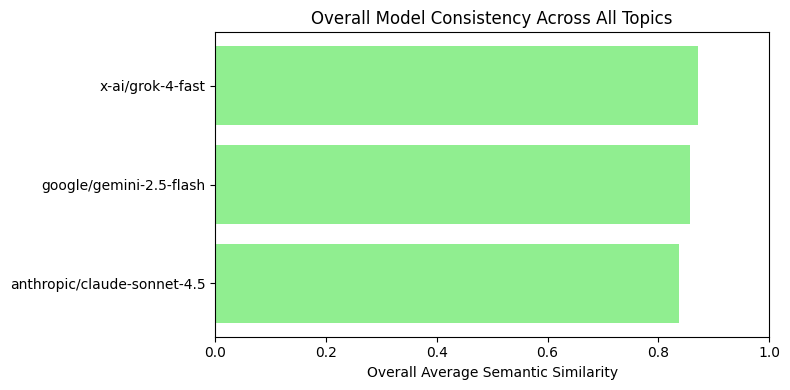

Leaderboard saved to: output/overall_leaderboard.png


In [21]:
# Create overall leaderboard
print("Creating overall leaderboard...")

plot_overall_leaderboard(avg_scores, save_path="output", show=True)

print("Leaderboard saved to: output/overall_leaderboard.png")
plt.show()


In [22]:
# Create topic-specific plots
print("Creating topic-specific plots...")

plot_similarity_by_sphere(avg_scores, save_path="output")

print("Topic plots saved to: output/")


Creating topic-specific plots...
Saved similarity by sphere plot to: output/similarity_by_sphere_Climate_Change.png
Saved similarity by sphere plot to: output/similarity_by_sphere_Vaccines.png
Saved similarity by sphere plot to: output/similarity_by_sphere_Artificial_Intelligence.png
Topic plots saved to: output/


In [23]:
# Create similarity heatmaps for each model/topic
print("Creating similarity heatmaps...")

for model in matrices:
    for topic in matrices[model]:
        safe_model = model.replace("/", "_")
        safe_topic = topic.replace(" ", "_")
        save_path = f"output/heatmap_{safe_model}_{safe_topic}.png"
        
        fig, ax = plot_similarity_matrix_with_values(
            similarity_matrix=matrices[model][topic],
            persona_ids=persona_ids[model][topic],
            show_values=(len(persona_ids[model][topic]) <= 20),
            model_name=model,
            topic=topic,
            save_path=save_path
        )
        plt.close(fig)

print("All heatmaps saved to: output/")


Creating similarity heatmaps...
All heatmaps saved to: output/


---

## Step 6: Analysis Part 1

Perform clustering and detect negative similarities.


In [24]:
print("Performing comprehensive analysis...")

analysis_results = analyze_and_cluster_embeddings(
    all_embeddings=embeddings,
    all_similarity_matrices=matrices,
    all_sorted_personas=persona_ids,
    max_clusters=10,
    random_state=42,
    save_plots=True,
    plots_dir="output/clustering"
)

print("\\nAnalysis complete!")

# Print summary
print_analysis_summary(analysis_results)


Performing comprehensive analysis...
Analyzing x-ai/grok-4-fast - Climate Change...
Analyzing x-ai/grok-4-fast - Vaccines...
Analyzing x-ai/grok-4-fast - Artificial Intelligence...
Analyzing anthropic/claude-sonnet-4.5 - Climate Change...
Analyzing anthropic/claude-sonnet-4.5 - Vaccines...
Analyzing anthropic/claude-sonnet-4.5 - Artificial Intelligence...
Analyzing google/gemini-2.5-flash - Climate Change...
Analyzing google/gemini-2.5-flash - Vaccines...
Analyzing google/gemini-2.5-flash - Artificial Intelligence...
\nAnalysis complete!

EMBEDDING ANALYSIS SUMMARY

Model: x-ai/grok-4-fast
----------------------------------------
  Topic: Climate Change
    No negative similarities found
    Optimal clusters: 2
    Plot saved: output/clustering/clustering_x-ai/grok-4-fast_Climate Change.png
  Topic: Vaccines
    No negative similarities found
    Optimal clusters: 2
    Plot saved: output/clustering/clustering_x-ai/grok-4-fast_Vaccines.png
  Topic: Artificial Intelligence
    No negati

---

## Step 7: Central Analysis

Compute weighted consistency metrics across models and topics.


In [4]:
print("Running central analysis...")

# Compute central analysis metrics
per_model_per_topic, model_overall_weighted, topic_across_models_weighted, benchmark = \
    compute_central_analysis(matrices, output_dir="output/analysis")


Running central analysis...
Central analysis complete!

Files saved to: output/analysis/
   - per_model_per_topic.csv
   - model_overall_weighted.csv
   - topic_across_models_weighted.csv
   - summary.txt
   - README.md


In [5]:
# Display results
print_central_analysis_summary(model_overall_weighted, topic_across_models_weighted, benchmark)


CENTRAL ANALYSIS RESULTS

Benchmark (mean of models' weighted means): 0.855392

--------------------------------------------------------------------------------
Top Models by Weighted Mean Similarity:
--------------------------------------------------------------------------------

                      model  weighted_mean_similarity  topics_count  total_pairs
           x-ai/grok-4-fast                  0.872517             3         3675
    google/gemini-2.5-flash                  0.856537             3         3675
anthropic/claude-sonnet-4.5                  0.837123             3         3675

--------------------------------------------------------------------------------
Top Topics by Response-Weighted Consistency:
--------------------------------------------------------------------------------

                  topic  response_weighted_topic_consistency  models_contributing  total_response_pairs
         Climate Change                             0.895669                    

---

## Experiment Complete

### What you just did:

- Loaded diverse personas from NVIDIA Nemotron dataset  
- Generated personalized queries for each persona  
- Queried multiple LLMs with adaptive concurrency  
- Computed semantic similarity across responses  
- Created comprehensive visualizations  
- Performed clustering analysis  
- Generated weighted consistency metrics and benchmark scores

### Understanding results:

**Similarity Scores:**
- **1.0** = Perfect consistency (identical facts)
- **0.8-0.99** = High consistency
- **0.5-0.8** = Moderate consistency -- some discrepancies and/or differences in focus
- **0.0-0.5** = Low consistency -- talking about totally unrelated things
- **Negative** = Opposing facts (contradictory information)

### Output Files:

**Visualizations** (`output/`):
- Heatmaps, leaderboards, and topic-specific plots
- Clustering analysis plots (`output/clustering/`)

**Central Analysis** (`output/analysis/`):
- `per_model_per_topic.csv` - detailed similarity metrics
- `model_overall_weighted.csv` - model rankings with weighted scores
- `topic_across_models_weighted.csv` - topic consistency across models
- `summary.txt` - benchmark and top-5 leaderboards
- `README.md` - documentation

### Next Steps:

1. **Explore visualizations and analysis results in `output/` directory**
2. Review the benchmark score and model rankings in `output/analysis/`
3. Adjust configuration and re-run
4. Try more models or topics
5. Share your findings!

---

**Built by the Duke Phishermen**  
Peter Banyas, Shristi Sharma, Alistair Simmons, Atharva Vispute

With inquiries, questions, & feedback, please contact: peter dot banyas at duke dot edu
